# ATM407 thermodynamics assignment: TPW and soundings

### Open these other browser tabs: 
http://weather.uwyo.edu/upperair/sounding.html

http://tropic.ssec.wisc.edu/real-time/mimic-tpw/global/main.html

### Also, launch the IDV and begin loading the bundle: 
Mapes Collection > Classes and Labs > MSC407 lab exercieses > Water_vapor_channel_1980-2015

--------------

# First, define 3 plotting functions
hit shift-return on these 3 code cells that begin with "def"

## 1. EnergyMassPlot

In [1]:
def EnergyMassPlot(dataset, label):
### Plot specific (per unit mass) static energies, as a function of pressure (mass)

    ### GRAB THE DATA
    p = dataset.variables['pressure'][:]
    T = dataset.variables['temperature'][:]
    Td = dataset.variables['dewpoint'][:]
    Z = dataset.variables['height'][:]
    u = dataset.variables['u_wind'][:]
    v = dataset.variables['v_wind'][:]

    
    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as mpunits
    from metpy.constants import Cp_d, Rd, Lv, g

    
    # FIGURE SETUP
    # fig, ax = plt.subplots(figsize=(11,8))

    ### Set up axes  
    ax.axis([250,400, 1050,100])
    right_annot_loc = 380
    
    ### Turn on and locate RCE reference annotations (thermo. energy = area on the diagram)
    RCE_ref = 'true'
    RCEloc = 260 # kJ/kg location on plot


    ### Label axes  
    ax.set_title('Conserved variables diagram: static energy '+label)
    ax.set_xlabel(
        'specific static energies: $\mathregular{s, s_v, h, h_{sat} \/(kJ\/kg^{-1})}$')
    ax.set_ylabel('p (hPa)')
 

    ### Some non-data-dependent standard annotations
    if(RCE_ref):
        ### Energy is area, draw reference boxes. 
        ax.plot    ([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
        ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')


        #### Radiative cooling reference
        ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
                [1000 , 1000    , 200     , 200, 1000],             
                linewidth=1, color='c', alpha=0.9)

        ax.annotate(' cooling $-1.3 K/d$',  xy=(RCEloc, 300), color='c')
        ax.annotate('$-10^7 J m^{-2}$', xy=(RCEloc, 330))

        #### Surface flux reference
        ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
                [1000 , 1000   , 910    , 910, 1000],             
                linewidth=1, color='orange', alpha=0.5)

        ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
        ax.annotate('116 $W m^{-2}$', xy=(RCEloc,940))
        ax.annotate(' for 1 day'     , xy=(RCEloc,960), fontsize=9)
        ax.annotate('=$10^7 J m^{-2}$'  , xy=(RCEloc, 990))


        
        
    ### The sounding data plot: need mixing ratios from T,Td
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    qs= mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)

    s = g*Z + Cp_d*T 
    sv= g*Z + Cp_d*mpcalc.virtual_temperature(T,q)
    h = s            + Lv*q
    hs= s            + Lv*qs

    ax.plot(s  /1000, p, color='r', linewidth=1.5)  ### /1000 for kJ/kg
    ax.plot(sv /1000, p, color='r', linestyle='-.') 
    ax.plot(h  /1000, p, color='b', linewidth=1.5) 
    ax.plot(hs /1000, p, color='r', linewidth=1.5) 

    

    ### RH rulings between s and h lines: annotate near 800 hPa level
    annot_level = 800 #hPa
    idx = np.argmin(np.abs(p - annot_level *mpunits.units.hPa))

    for iRH in np.arange(10,100,10):
        ax.plot( (s+ Lv*qs*iRH/100.)/1000, p, linewidth=0.5, linestyle=':', color='k')
        ax.annotate(str(iRH), xy=( (s[idx]+Lv*qs[idx]*iRH/100.)/1000, annot_level),                    
                    horizontalalignment='center',fontsize=6)
    ax.annotate('RH (%)', xy=(right_annot_loc, annot_level), fontsize=10)



### Lifted parcels in green, but only if there is undilute CAPE that is nontrivial (>10 J/kg, say)
# Nontrivial test is used because MetPy CAPE is sometimes some small value just within the PBL or something
# Calculate lifted undilute parcel temperatue profile.
    parcel_Tprofile = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    CAPE,CIN = mpcalc.cape_cin(p,T,Td,parcel_Tprofile)
    ELp,ELT = mpcalc.el(p,T,Td)
    ELindex = np.argmin(np.abs(p - ELp))

    # print(CAPE,CIN)

    if ~np.isnan(CAPE.magnitude):
        if CAPE.magnitude >10:  
            parcelh  = h [0]        # for a layer mean: np.mean(h[idx1:idx2])
            parcelsv = sv[0]
            parcelp0 = p[0]

            # Undilute parcel
            ax.plot( (1,1)*parcelh/1000., (1,0)*parcelp0, linewidth=0.5, color='g')
            maxbindex = np.argmax(parcel_Tprofile - T)
            ax.annotate('CAPE='+str(int(CAPE.magnitude)), 
                        xy=(parcelh/1000., p[maxbindex]), color='g')

            # Plot LCL at saturation point, above the lifted sv of the surface parcel 
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
            ax.annotate('LCL', xy=(sv[0]/1000., lcl_pressure), fontsize=10, color='g', horizontalalignment='right')
            # Purple fill for negative buoyancy below LCL:
            ax.fill_betweenx(p, sv/1000., parcelsv/1000., where=p>lcl_pressure, facecolor='purple', alpha=0.4)

            # Positive moist convective buoyancy in green 
            # Above LCL:
            ax.fill_betweenx(p, hs/1000., parcelh/1000., where= parcelh>hs, facecolor='g', alpha=0.4)


            # Depict Entraining parcels
            # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
            # M=1 at ground without loss of generality
            entrainment_distance = 10000., 5000., 2000. 
            ax.annotate('entrain: 10,5,2 km',  xy=(parcelh/1000, 140), color='g', 
                        fontsize=8, horizontalalignment='right')
            ax.annotate('parcel h',            xy=(parcelh/1000, 120), color='g', 
                        fontsize=10, horizontalalignment='right')

            for ED in entrainment_distance: 
                eps = 1.0 / (ED*mpunits.units('m'))
                M = np.exp(eps * (Z-Z[0]).to('m')).to('dimensionless')

                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)

                # parcel mass is a  sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages 
                hent = np.cumsum(dM*h) / np.cumsum(dM)

                ax.plot( hent[0:ELindex+3]/1000., p[0:ELindex+3], linewidth=0.5, color='g')




    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    dZ = 100 *mpunits.units.meter

    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*mpunits.units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dp: hydrostatic
        rho = (p[idx]/Rd/T[idx])
        dp = -rho*g*dZ

        # dhsat
        #qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T)     ,p)
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) -qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (hs[idx]+dhs*(-1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (s [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (h [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 600*ilev.units:
            ax.plot(right_annot_loc*hs.units +dhs*(-1,1)/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('100m internal waves', xy=(right_annot_loc,600), fontsize=8)



    ### Blue fill proportional to precipitable water, and blue annotation
    ax.fill_betweenx(p, s/1000., h/1000., where=h > s, facecolor='b', alpha=0.4)

    import metpy.calc as mpcalc
    PW = mpcalc.precipitable_water(Td,p)
    PWs = mpcalc.precipitable_water(T,p)
    CRH = (PW/PWs).magnitude *100. 

    # PW annotation arrow tip at 700 mb
    idx = np.argmin(np.abs(p - 700*p.units))
    centerblue = (s[idx]+h[idx])/2.0 /1000.

    ax.annotate('CWV='+str(round(PW.to('mm').magnitude, 1))+'mm',
                xy=(centerblue, 700), xytext=(285, 200), 
                color='blue', fontsize=15,
                arrowprops=dict(width = 1, edgecolor='blue', shrink=0.02),
                )
    ax.annotate('(' + str(round(CRH,1)) +'% of sat)',
                xy=(285, 230), color='blue', fontsize=12)



    ### Surface water values at 1C intervals, for eyeballing surface fluxes
    sT = np.trunc(T[0].to('degC'))
    sTint = int(sT.magnitude)

    for idT in [-2,0,2,4]:
        ssTint = sTint + idT # UNITLESS degC integers, for labels

        # Kelvin values for computations
        ssTC = ssTint *mpunits.units('degC')
        ssTK = ssTC.to('kelvin')
        ss = g*Z[0] + Cp_d*ssTK 
        hs = ss     + Lv*mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(ssTK) ,p[0])

        ax.annotate(str(ssTint), xy=(ss/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=7)
        ax.annotate(str(ssTint), xy=(hs/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=9)
        ax.annotate('\u00b0C water', xy=(right_annot_loc, p[0]), verticalalignment='top', 
                    fontsize=10, color='r')


    plt.show()

## 2. Skew-T Plotting function
----------------------------

With fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are useful when performing further analysis on the Skew-T diagram. Often the 0C isotherm is emphasized and areas of CAPE and CIN are shaded.


In [2]:
def skewTplot(dataset, label):
### Plot specific (per unit mass) static energies, as a function of pressure (mass)

    ### GRAB THE DATA
    p = dataset.variables['pressure'][:]
    T = dataset.variables['temperature'][:]
    Td = dataset.variables['dewpoint'][:]
    Z = dataset.variables['height'][:]
    u = dataset.variables['u_wind'][:]
    v = dataset.variables['v_wind'][:]

    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as mpunits
    from metpy.constants import Cp_d, Rd, Lv, g
    from metpy.plots import Hodograph, SkewT
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # FIGURE SETUP
    # fig, ax = plt.subplots(figsize=(11,8))

    # Calculate the LCL
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    # print(lcl_pressure, lcl_temperature)

    # Calculate the parcel temperatue profile.
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

    # Create a new figure. The dimensions here give a good aspect ratio
    # fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, T, 'r')
    skew.plot(p, Td, 'g')
    skew.plot_barbs(p, u, v)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_xlim(-40, 60)

    # Plot LCL as black dot
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Plot the parcel profile as a black line
    skew.plot(p, parcel_prof, 'k', linewidth=2)

    # Color regions of CAPE and CIN (the area between the actual temperature and
    # the parcel path).
    skew.ax.fill_betweenx(p, T, parcel_prof, where=T >= parcel_prof, facecolor='blue', alpha=0.4)
    skew.ax.fill_betweenx(p, T, parcel_prof, where=T < parcel_prof, facecolor='red', alpha=0.4)

    # Plot a zero degree isotherm
    l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    # Create a hodograph
    # Create an inset axes object that is 40% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=80.)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, np.hypot(u, v))  # Plot a line colored by wind speed

    # Show the plot
    plt.show()

## 3. Potential temperatures plot

In [3]:
def pot_temps_plot(dataset, label): 
    
    ### GRAB THE DATA
    p = dataset.variables['pressure'][:]
    T = dataset.variables['temperature'][:]
    Td = dataset.variables['dewpoint'][:]
    Z = dataset.variables['height'][:]
    u = dataset.variables['u_wind'][:]
    v = dataset.variables['v_wind'][:]
    
    
    ### Plot equivalent temperatures
    ### Set up axes and ranges 
    ax.set_xlabel('$\mathregular{\\theta, \\theta_e, \\theta_e^{sat} \/(K)}$') 
    #    'Potential temperatures: $\mathregular{\theta, \theta_e, \theta_e_s \/K$')
    ax.set_ylabel('p (hPa)')
    ax.axis([270,380, 1050,100])
    ax.set_title(label + ' potential temperatures')


    #    Tracer()()  # debugging
    theta  = mpcalc.potential_temperature(p,T)
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    thetav = mpcalc.virtual_potential_temperature(p,T,q)
    thetae = mpcalc.equivalent_potential_temperature(p, T, Td)
    thetaes= mpcalc.equivalent_potential_temperature(p, T, T)


    ax.plot(theta  , p, color='r', linewidth=2.0) 
    ax.plot(thetav , p, color='r', linestyle='-.') 
    ax.plot(thetae , p, color='b', linewidth=2.0) 
    ax.plot(thetaes, p, color='r', linewidth=2.0)

    ### Lifted parcel 
    parcel_the = thetae[0]        # for a layer mean: np.mean(thetae[idx1:idx2])
    ax.plot( (1,1)*parcel_the, (1100,0), linewidth=0.5, color='g')
    ax.annotate('surface parcel',  xy=(parcel_the, 130), color='g', fontsize=8)

    plt.show()

------------------

# Next, let's test it on a Miami sounding

In [4]:
%matplotlib inline 
# makes plots appear inline in the notebook

In [5]:
# import needed modules

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
import metpy.units as mpunits
from metpy.io import get_upper_air_data

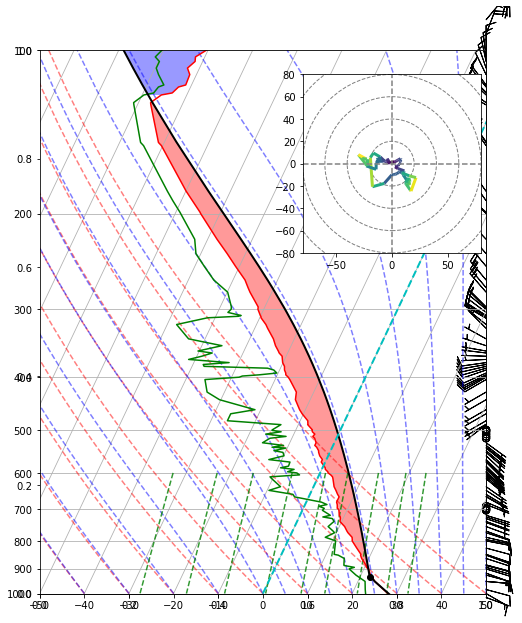

In [6]:
# Year, Month, Day, Hour (0 or 12) 
# Miami in summer
sounding = get_upper_air_data(datetime(2013, 8, 25, 0), 'MFL')
label = 'Miami 2013-8-25-0'

fig, ax = plt.subplots(figsize=(8,10))
skewTplot(sounding, label)

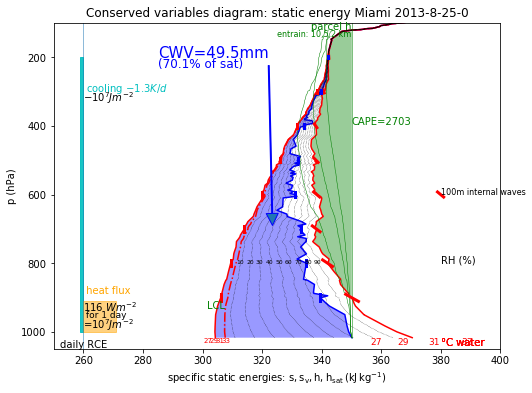

In [7]:
fig, ax = plt.subplots(figsize=(8,6))
EnergyMassPlot(sounding, label)

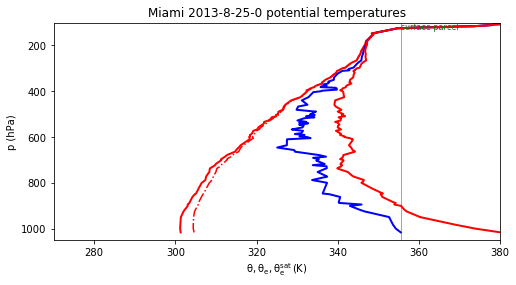

In [8]:
fig, ax = plt.subplots(figsize=(8,4))
pot_temps_plot(sounding, label)

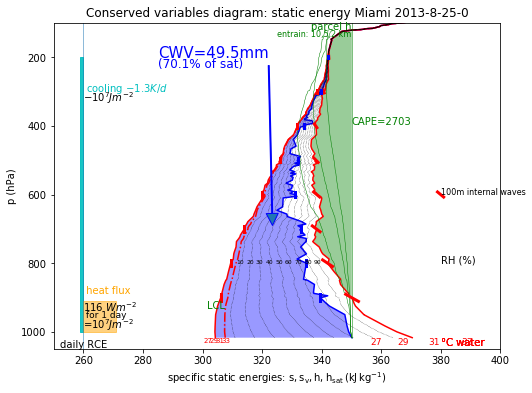

In [9]:
# Miami in summer
sounding = get_upper_air_data(datetime(2013, 8, 25, 0), 'MFL')
label = 'Miami 2013-8-25-0'

fig, ax = plt.subplots(figsize=(8,6))
EnergyMassPlot(sounding, label)

Your Assignment: 
-----------------

We want to see how soundings relate to dry and moist airmasses as seen in satellite imagery: 
1. TPW imagery from the MIMIC site: proportional to blue ink area in the EnergyMassPlot
2. "Water vapor channel" IR imagery as seen in your IDV bundle

To do this, fish around in the MIMIC archives (at bottom of that page). **Pick some unique  situation (different from other students)** when an interesting moisture change sweeps over some sounding site (as seen in the Wyoming soundings page). Anywhere in the world! Set the IDV's Time Driver to that time, to see what the WV IR channel saw. A very different view from the microwave-derived TPW, isn't it!


Find the Wyoming sounding site code for your sounding location by mouse-hovering over it, and examine their skew-T plots for your dates to be sure the data are avalilable. 


### 1. Capture images of your water vapor  situation
using either the Image command, or if you use an animated .gif, the 4-line version. 

These can be images from the MIMIC site, or captured from your IDV session, or both. 

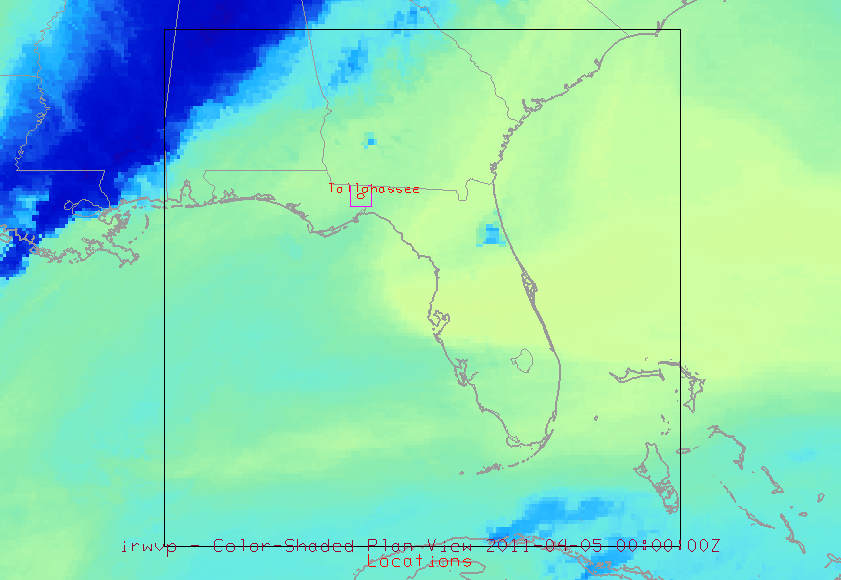

In [17]:
# Importing an image
from IPython.display import Image
Image("/Users/Nick/Desktop/PWC_11.png")

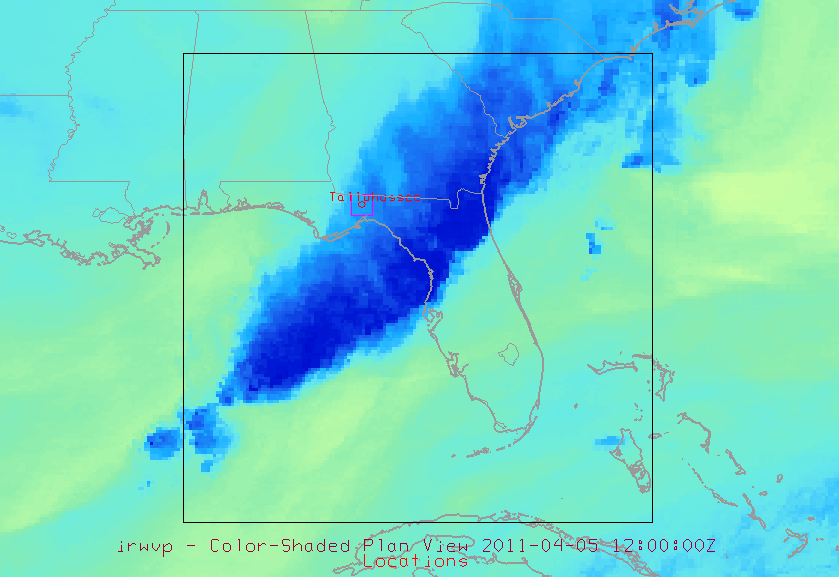

In [10]:
# Importing an image
from IPython.display import Image
Image("/Users/Nick/Desktop/PWC_2.png")

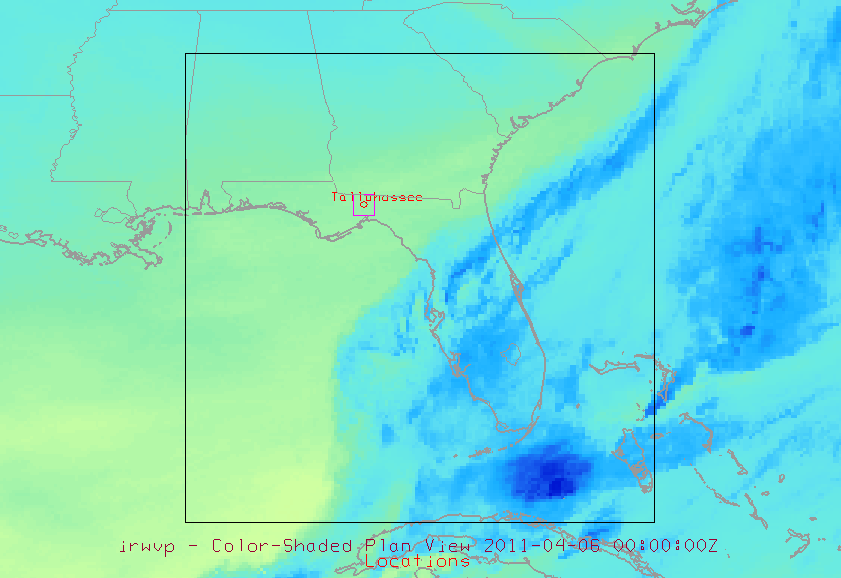

In [12]:
# Importing an image
from IPython.display import Image
Image("/Users/Nick/Desktop/PWC_4.png")

In [12]:
# Importing an animated .gif
from IPython.display import Image
from IPython.display import display
with open('/Users/bem/Downloads/dummy.gif','rb') as f:
    display(Image(f.read()), format='png')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/bem/Downloads/dummy.gif'

### 2. Using the Wyoming site's code for your sounding location, make EnergyMassPlot plots that show the moisture change


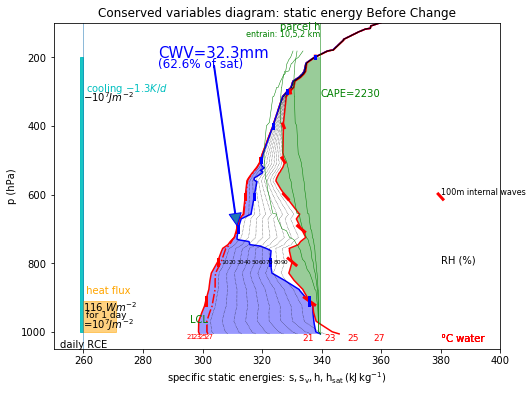

In [14]:
# My case before the moisture change
sounding = get_upper_air_data(datetime(2011, 4, 5, 0), 'TLH')
label = 'Before Change'

fig, ax = plt.subplots(figsize=(8,6))
EnergyMassPlot(sounding, label)

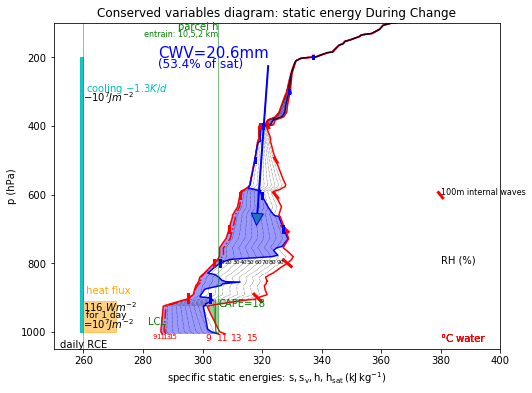

In [15]:
# My case during the moisture change
sounding = get_upper_air_data(datetime(2011, 4, 5, 12), 'TLH')
label = 'During Change'

fig, ax = plt.subplots(figsize=(8,6))
EnergyMassPlot(sounding, label)

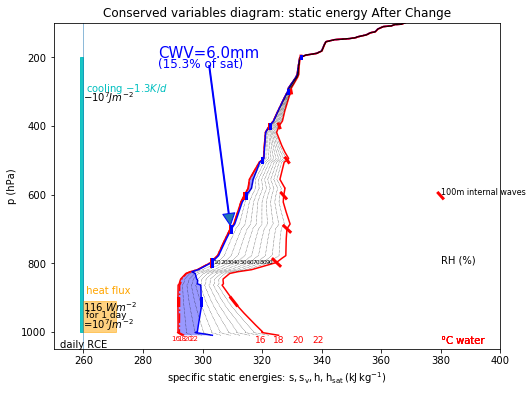

In [16]:
# My case after the moisture change
sounding = get_upper_air_data(datetime(2011, 4, 6, 0), 'TLH')
label = 'After Change'

fig, ax = plt.subplots(figsize=(8,6))
EnergyMassPlot(sounding, label)

## Discuss what you saw about your case: 

At what levels was the satellite-detected moisture change? 

Discussion: 
-----------


Prior to the passing of the cold front, the atmospheric environment above Tallahassee was a stereotypically "unstable" environment as per the 9/5 00Z sounding. An average Florida CAPE value is present along with substantial low level (>750 hPa) column water vapor content (32.3 mm) and low level winds out of the SW. The 12Z sounding on 9/5 catches the tail end of the frontal passage. A large frontal inversion has developed at ~750 m which acts to susbstantially increase atmospheric stability. Mid-level moisture has also increased noticably around 600-800 hPa while the low level moist region present in the 00Z sounding has decreased significantly but is still somewhat present. The 00Z sounding on 9/6 reveals a traditional post-cold front passage atmospheric profile. The column is almost devoid of moisture save for the 6 mm CWV available between 800-1000 hPa. The frontal inversion has matured and occurs at a slightly higher altitude than in the 9/5 12Z sounding. A gradual wind shift from SW to W to NW is noticeable as the cold front passes through the region.


NameError: name 'Markdown' is not defined

------------- resources for your convenience ---------------

In [ ]:
# a loop to display several soundings
for imo in range(1,12):
    sounding = get_upper_air_data(datetime(2016, imo, 1, 0), 'DNR')
    label = 'DNR '+str(2016)+'-'+str(imo)+'-'+str(1)+'-'+str(0)
    
    fig, ax = plt.subplots(figsize=(8,6))
    EnergyMassPlot(sounding, label)

### Plots of specific static energy vs. mass (pressure)

Dry static energy (s= CpT + gZ), water vapor mixing ratio (q), and therefore moist static energy (h= s + Lq) are useful for these reasons: 

1. They are conserved for vertical motions (air parcel pressure changes), like dry and moist entropy, or theta and theta-e in the potential temperature treatment of thermodynamics. 

2. They mix linearly: hmix = (h1+h2)/2 for equal mixtures between air parcels with h1 and h2. 

Because pressure is a mass coordinate, area on such a diagram is proportional to column integrated energy (J/ m^2). For instance, the total latent energy L*CWV or simply CWV (precipitable water) is the blue area in the diagram. The approximations in this system are that Cp and the denominator of vapor content (mixing ratio, not specific humidity) are treated as constants (the dry-air values). Also, L is also taken as constant (at the reference temperature). Z is related to pressure by the hydrostatic approximation. These approximations are acceptable for all conditions on Earth, including lifted-parcel buoyancy computations for inferring convection, as verifiable by comparing to the comparable theta, theta-e, theta-e-sat diagram readily computed from the sophisticated nonlinear-LOOKING formulas for those. All those complicated apparent nonlinearities can be scrapped in favor of this lucid, linear "energy in buckets" reasoning to very good approximation, as most researchers know well (and choose for their own clarity). 